### Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Splitting Data

In [2]:
base_dir = r'D:\kuliah\Tel-U\penting\tugas\semester 8\Tugas Akhir\CodeModel'
normal_dir = os.path.join(base_dir, 'normal')
pneumonia_dir = os.path.join(base_dir, 'pneumonia')

normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)]

normal_labels = [0] * len(normal_images)
pneumonia_labels = [1] * len(pneumonia_images)

all_images = normal_images + pneumonia_images
all_labels = normal_labels + pneumonia_labels

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


### Preprocessing Data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Flow from directory untuk training
train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Flow from directory untuk validation
val_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Flow from directory untuk testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 541 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 675 images belonging to 2 classes.


In [4]:
print("Training Generator:", train_generator.samples)
print("Validation Generator:", val_generator.samples)
print("Test Generator:", test_generator.samples)

Training Generator: 541
Validation Generator: 134
Test Generator: 675


### ResNet152 Model

In [5]:
def create_resnet152_model():
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet152_model = create_resnet152_model()

234698864/234698864 [==============================] - 114s 0us/step


### Train Model

In [6]:
history = resnet152_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
17/17 [==============================] - 45s 2s/step - loss: 0.7186 - accuracy: 0.6081 - val_loss: 0.6395 - val_accuracy: 0.6567
Epoch 2/50
17/17 [==============================] - 22s 1s/step - loss: 0.7174 - accuracy: 0.5693 - val_loss: 0.6391 - val_accuracy: 0.6567
Epoch 3/50
17/17 [==============================] - 22s 1s/step - loss: 0.6798 - accuracy: 0.6266 - val_loss: 0.6282 - val_accuracy: 0.6567
Epoch 4/50
17/17 [==============================] - 21s 1s/step - loss: 0.6708 - accuracy: 0.6285 - val_loss: 0.6271 - val_accuracy: 0.6567
Epoch 5/50
17/17 [==============================] - 20s 1s/step - loss: 0.6665 - accuracy: 0.6248 - val_loss: 0.6152 - val_accuracy: 0.6567
Epoch 6/50
17/17 [==============================] - 22s 1s/step - loss: 0.6659 - accuracy: 0.6340 - val_loss: 0.6161 - val_accuracy: 0.6567
Epoch 7/50
17/17 [==============================] - 21s 1s/step - loss: 0.6647 - accuracy: 0.6285 - val_loss: 0.6119 - val_accuracy: 0.6567
Epoch 8/50
17/17 [==

### evaluate model

In [7]:
def evaluate_model(model, test_generator):
    y_pred = model.predict(test_generator)
    y_pred = np.round(y_pred).astype(int)
    y_true = test_generator.classes

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

    return accuracy, precision, recall, f1

print("Evaluating ResNet152")
accuracy, precision, recall, f1 = evaluate_model(resnet152_model, test_generator)

Evaluating ResNet152
22/22 [==============================] - 17s 672ms/step
Accuracy: 0.8222222222222222
Precision: 0.801125703564728
Recall: 0.9682539682539683
F1-Score: 0.8767967145790554


In [8]:
import pandas as pd

results = {
    'Model': ['ResNet101'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
}


df_results = pd.DataFrame(results)

22/22 [==============================] - 16s 731ms/step


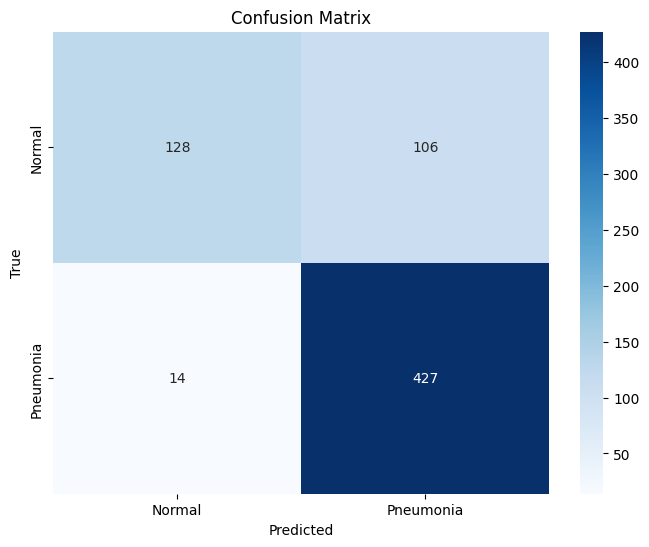

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi pada data test
y_pred = resnet152_model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Ambil history dari pelatihan
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

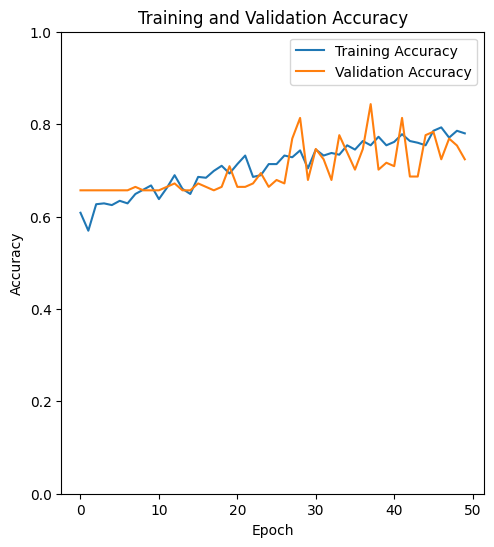

In [11]:
# plot akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.legend()

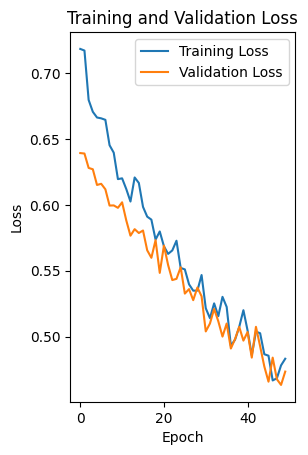

In [12]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
def plot_images(images, true_labels, predicted_labels, class_names, correct=True):
    """
    Menampilkan gambar dengan label benar dan prediksi.

    Parameters:
        images (list): List gambar.
        true_labels (list): List label benar.
        predicted_labels (list): List label prediksi.
        class_names (list): Nama kelas (['Normal', 'Pneumonia']).
        correct (bool): Jika True, tampilkan prediksi yang benar. Jika False, tampilkan prediksi yang salah.
    """
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        
        # Konversi label ke integer
        true_label = int(true_labels[i])
        pred_label = int(predicted_labels[i][0])  # predicted_labels adalah array 2D
        
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')
    plt.suptitle('Correct Predictions' if correct else 'Incorrect Predictions')
    plt.show()

In [ ]:
test_images, test_labels = next(test_generator)

# Prediksi kelas
predictions = resnet152_model.predict(test_images)
predicted_classes = np.round(predictions).astype(int)

# Mengambil true labels dari generator
y_true = test_generator.classes

# Mengambil beberapa contoh yang benar dan salah
correct_images = []
correct_true_labels = []
correct_pred_labels = []

incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []


correct_indices = []
incorrect_indices = []

# Loop melalui batch generator untuk mengambil gambar
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    preds = resnet152_model.predict(images)
    preds_classes = np.round(preds).astype(int)


    correct_indices_batch = np.where(preds_classes.flatten() == labels)[0]
    incorrect_indices_batch = np.where(preds_classes.flatten() != labels)[0]


    correct_indices.extend(correct_indices_batch + i * test_generator.batch_size)
    incorrect_indices.extend(incorrect_indices_batch + i * test_generator.batch_size)


    for j in correct_indices_batch:
        correct_images.append(images[j])
        correct_true_labels.append(labels[j])
        correct_pred_labels.append(preds_classes[j])
    for j in incorrect_indices_batch:
        incorrect_images.append(images[j])
        incorrect_true_labels.append(labels[j])
        incorrect_pred_labels.append(preds_classes[j])


    if len(correct_images) >= 9 and len(incorrect_images) >= 9:
        break
# Ambil 9 sampel pertama
correct_images = correct_images[:9]
correct_true_labels = correct_true_labels[:9]
correct_pred_labels = correct_pred_labels[:9]

incorrect_images = incorrect_images[:9]
incorrect_true_labels = incorrect_true_labels[:9]
incorrect_pred_labels = incorrect_pred_labels[:9]

# Nama kelas
class_names = ['Normal', 'Pneumonia']

1/1 [==============================] - 0s 51ms/step


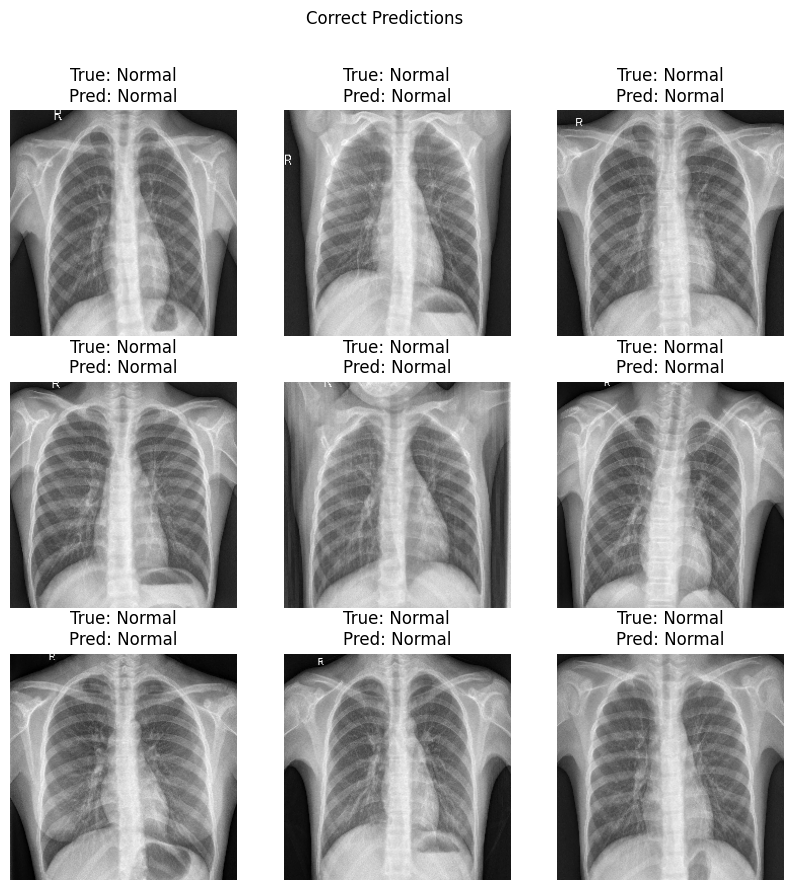

In [ ]:
# Tampilan prediksi yang benar
plot_images(correct_images, correct_true_labels, correct_pred_labels, class_names, correct=True)

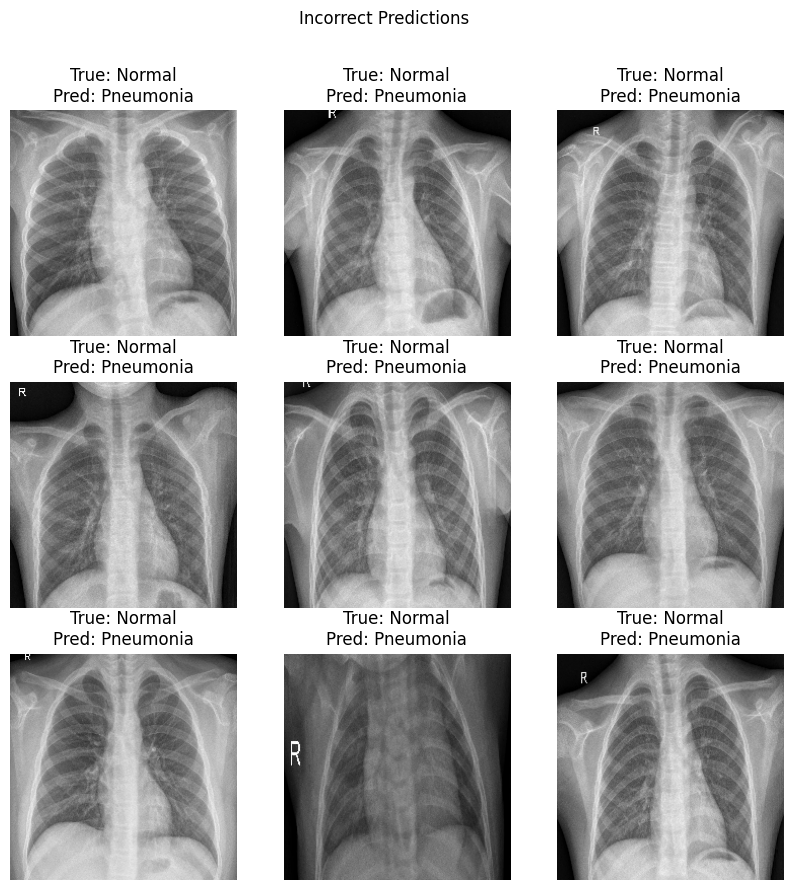

In [ ]:
# Tampilan prediksi yang salah
plot_images(incorrect_images, incorrect_true_labels, incorrect_pred_labels, class_names, correct=False)

In [17]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hitung jumlah prediksi yang salah
false_normal = cm[0, 1]  # True: Normal, Pred: Pneumonia
false_pneumonia = cm[1, 0]  # True: Pneumonia, Pred: Normal

# Total prediksi yang salah
total_false = false_normal + false_pneumonia

# Tampilkan hasil
print(f"Jumlah prediksi salah (True: Normal, Pred: Pneumonia): {false_normal}")
print(f"Jumlah prediksi salah (True: Pneumonia, Pred: Normal): {false_pneumonia}")
print(f"Total prediksi yang salah: {total_false}")

Jumlah prediksi salah (True: Normal, Pred: Pneumonia): 106
Jumlah prediksi salah (True: Pneumonia, Pred: Normal): 14
Total prediksi yang salah: 120


In [18]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hitung jumlah prediksi yang benar
true_normal = cm[0, 0]  # True: Normal, Pred: Normal
true_pneumonia = cm[1, 1]  # True: Pneumonia, Pred: Pneumonia

# Total prediksi yang benar
total_true = true_normal + true_pneumonia

# Tampilkan hasil
print(f"Jumlah prediksi benar (True: Normal, Pred: Normal): {true_normal}")
print(f"Jumlah prediksi benar (True: Pneumonia, Pred: Pneumonia): {true_pneumonia}")
print(f"Total prediksi yang benar: {total_true}")

Jumlah prediksi benar (True: Normal, Pred: Normal): 128
Jumlah prediksi benar (True: Pneumonia, Pred: Pneumonia): 427
Total prediksi yang benar: 555
